EXample to plot the results, case 3

In [3]:

case_settings = {
    "case1": {"true_vals": [-176, -92, -186], "true_lithology": 26, "true_delta": 1},
    "case2": {"true_vals": [-314, -244, -362], "true_lithology": 45, "true_delta": 1},
    "case3": {"true_vals": [-226, -172, -262], "true_lithology": 48, "true_delta": 1},
    "case4": {"true_vals": [-94, -10, -124], "true_lithology": 66, "true_delta": 2},
    "case5": {"true_vals": [-200, -106, -206], "true_lithology": 67, "true_delta": 2},
    "case6": {"true_vals": [-214, -142, -228], "true_lithology": 75, "true_delta": 2},
}

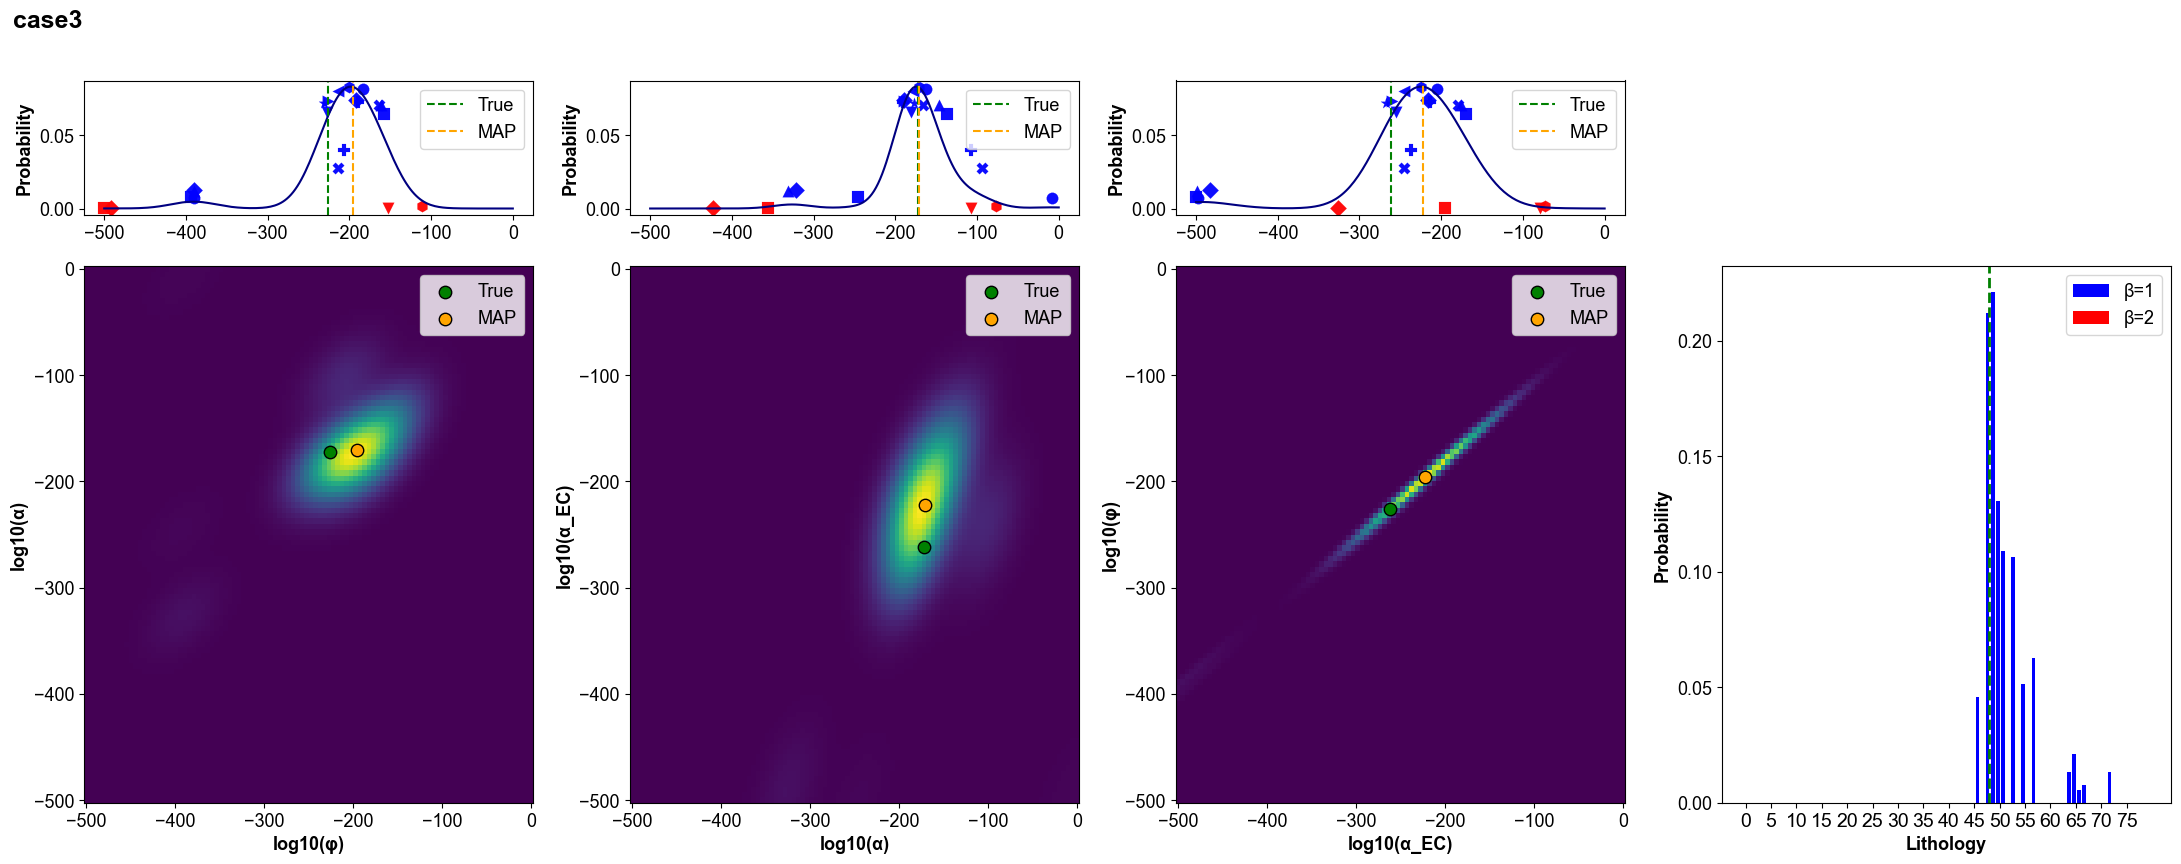

In [10]:

from collections import defaultdict, Counter

import pandas as pd
import numpy as np
import glob
import re
from collections import Counter

# Step 1: 读取所有 Δ 文件，构建 sample_pool
sample_pool = []

# 文件夹路径，修改为你自己的路径
folder_path = r"D:\forward_model_results\2024_4_11_margnial_discrete\step2_MC\case_new_all_2\case3\\"

# 搜索所有 obj_lith*_ibeta*.xlsx 文件
file_list = glob.glob(folder_path + 'obj_lith*_ibeta*.csv')

print(f"Found {len(file_list)} files.")

# 逐个文件读取
for file in file_list:
    # 解析 Δ_label
    match = re.search(r'obj_lith(\d+)_ibeta(\d+)', file)
    if match:
        lith_num = int(match.group(1))
        ibeta_num = int(match.group(2))
        delta_label = (lith_num, ibeta_num)
    else:
        print(f"Filename format not matched: {file}")
        continue
    
    # 读取文件
    df = pd.read_csv(file)
    
    # 逐行加入 sample_pool
    for _, row in df.iterrows():
        x_i = (row['phi'], row['alpha'], row['alpha_EC'])
        E0_i = row['obj']
        sample_pool.append( (delta_label, x_i, E0_i) )

print(f"Total samples collected: {len(sample_pool)}")
def revised_plotting_core(
    log_theta_top, 
    prob_est,
    MAP_log_theta,
    log_true_vals,
    delta_top,      
    delta_prob,
    case_name,
    out_path,
    true_lith,
    true_beta,
    T
):
    import os
    import matplotlib.pyplot as plt
    from matplotlib.lines import Line2D
    from matplotlib import cm
    from scipy.stats import gaussian_kde
    import numpy as np

    fig, axs = plt.subplots(2, 4, figsize=(22, 9), gridspec_kw={'height_ratios': [1, 4]})
    plt.rcParams.update({'font.family': 'Arial', 'font.size': 13})

    # Color by lithology
    liths = np.array([d[0] for d in delta_top])
    ibetas = np.array([d[1] for d in delta_top])
    unique_liths = np.unique(liths)
    marker_list = ['o', 's', '^', 'D', 'P', 'X', '*', 'v', '<', '>', 'h', '+']
    unique_liths = np.unique(liths)
    lith_marker_map = {lith: marker_list[i % len(marker_list)] for i, lith in enumerate(unique_liths)}
    markers = [lith_marker_map[l] for l in liths]

    # lith_color_map = {lith: cm.tab20(i % 20) for i, lith in enumerate(unique_liths)}
    # colors = [lith_color_map[l] for l in liths]
    color_map = {1: 'blue', 2: 'red'}
    colors = [color_map[b] for b in ibetas]

    # # Marker by ibeta
    # marker_map = {1: 'o', 2: 's'}
    # markers = [marker_map[b] for b in ibetas]

    # ---- 上排：边缘分布 ----
    for i, param in enumerate(["log10(φ)", "log10(α)", "log10(α_EC)"]):
        ax = axs[0, i]
        kde_1d = gaussian_kde(log_theta_top[:, i], weights=prob_est)
        x_vals = np.linspace(-500, 0, 200)
        p_vals = kde_1d(x_vals)
        max_scatter_y = np.max(prob_est)
        if p_vals.max() > 0:
            p_vals_scaled = p_vals / p_vals.max() * max_scatter_y
        else:
            p_vals_scaled = p_vals  # 避免被零除

        ax.plot(x_vals, p_vals_scaled, color='navy')
        
        for idx in range(len(log_theta_top)):
            ax.scatter(log_theta_top[idx, i],prob_est[idx], # y=0即可，视觉是X轴散点
                   c=[colors[idx]], marker=markers[idx], s=70,  linewidths=0.1, alpha=0.95)

        ax.axvline(log_true_vals[i], color='green', linestyle='--', label='True')
        ax.axvline(MAP_log_theta[i], color='orange', linestyle='--', label='MAP')
        ax.set_ylabel("Probability", fontweight='bold')
        ax.legend()

    # ---- 下排：联合分布 ----
    pairs = [(0, 1), (1, 2), (2, 0)]
    for j, (i, k) in enumerate(pairs):
        ax = axs[1, j]
        kde_2d = gaussian_kde(log_theta_top[:, [i, k]].T, weights=prob_est)
        x_grid = np.linspace(-500, 0, 100)
        y_grid = np.linspace(-500, 0, 100)
        X, Y = np.meshgrid(x_grid, y_grid)
        pos = np.vstack([X.ravel(), Y.ravel()])
        Z = kde_2d(pos).reshape(X.shape)
        pcm = ax.pcolormesh(X, Y, Z, shading='auto', cmap='viridis')

        # # 每个样本点散点图
        # for idx in range(len(log_theta_top)):
        #     ax.scatter(log_theta_top[idx, i], log_theta_top[idx, k],
        #                c=[colors[idx]], marker=markers[idx], s=40, edgecolor='k', linewidths=0.3)

        ax.scatter(log_true_vals[i], log_true_vals[k], c='green', s=80, edgecolor='k',label='True')
        ax.scatter(MAP_log_theta[i], MAP_log_theta[k], c='orange',  s=80, edgecolor='k',label='MAP')
        ax.set_xlabel(["log10(φ)", "log10(α)", "log10(α_EC)"][i], fontweight='bold')
        ax.set_ylabel(["log10(φ)", "log10(α)", "log10(α_EC)"][k], fontweight='bold')
        ax.legend()

    # ---- 条形图 ----
    ax = axs[1, 3]
    x = np.arange(80)
    y_liq1 = np.zeros_like(x, dtype=float)
    y_liq2 = np.zeros_like(x, dtype=float)
    for (lith, beta), prob in delta_prob.items():
        if 0 <= lith < 80:
            if beta == 1:
                y_liq1[lith] += prob
            elif beta == 2:
                y_liq2[lith] += prob
    bar_width = 0.7
    ax.bar(x - bar_width / 2, y_liq1, width=bar_width, label='β=1', color='blue')
    ax.bar(x + bar_width / 2, y_liq2, width=bar_width, label='β=2', color='red')
    ax.axvline(true_lith, color='green', linestyle='--', linewidth=2)
    ax.set_xticks(np.arange(0, 80, 5))
    ax.set_xticklabels(np.arange(0, 80, 5), rotation=0, fontname='Arial', fontsize=14)
    ax.set_xlabel("Lithology", fontweight='bold')
    ax.set_ylabel("Probability", fontweight='bold')
    ax.legend()
    fig.delaxes(axs[0, 3])
    fig.suptitle(f"{case_name}", x=0.01, y=0.96, ha='left', fontsize=18, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.95])

    os.makedirs(out_path, exist_ok=True)
    save_path = os.path.join(out_path, f"{case_name}_T{T}_posterior_summary_colored_new.pdf")
    plt.savefig(save_path, format='pdf')
    plt.show()
    plt.close()
    return save_path

def estimate_joint_posterior_with_clustering_and_visualization(
    sample_pool, T=0.01, n_clusters=3000, top_percent=0.1, case_name=0.1, case_settings=None, out_path=None
):

    best_sample_dict = {}  # key: delta, value: (log_theta, weight)
    for sample in sample_pool:
        delta = tuple(sample[0])
        theta = sample[1]
        log_theta_sample = np.log10(theta) * 100
        misfit = sample[2]
        weight = np.exp(-misfit / T)
        # weight/= np.sum(weight)
        if delta not in best_sample_dict or weight > best_sample_dict[delta][1]:
            best_sample_dict[delta] = (log_theta_sample, weight)

    weight/= np.sum(weight)
    log_theta_top = np.array([v[0] for v in best_sample_dict.values()])
    weights_top = np.array([v[1] for v in best_sample_dict.values()])
    delta_top = np.array(list(best_sample_dict.keys()))
   
    kde = gaussian_kde(log_theta_top.T, weights=weights_top)
    kde_vals = kde(log_theta_top.T)

    dx, dy, dz = [np.ptp(log_theta_top[:, i]) / 100 for i in range(3)]
    voxel_volume = dx * dy * dz
    prob_est = kde_vals * voxel_volume
    prob_est /= np.sum(prob_est)
    max_idx = np.argmax(prob_est)
    MAP_log_theta = log_theta_top[max_idx]   

    
    # 90% credible region索引
    idx_sorted = np.argsort(prob_est)[::-1]
    cumsum_prob = np.cumsum(prob_est[idx_sorted])
    credible_mask = cumsum_prob <= 0.9
    credible_indices = idx_sorted[credible_mask]
    credible_min_density = np.min(prob_est[credible_indices])
    credible_points = log_theta_top[credible_indices]
    mins = credible_points.min(axis=0)
    maxs = credible_points.max(axis=0)


    E0_array = np.array([sample[2] for sample in sample_pool])
    weights_all = np.exp(-E0_array / T)
    log_theta_all = np.log10(np.array([sample[1] for sample in sample_pool])) * 100
    delta_all = np.array([tuple(sample[0]) for sample in sample_pool])
    high_weight_indices = np.where(weights_all > 0.9)[0]
    log_theta_high = log_theta_all[high_weight_indices]
    delta_high = delta_all[high_weight_indices]
    weights_high = weights_all[high_weight_indices]

    
    # 4.1 筛选所有样本中落在credible region内的
    mask = (
    (log_theta_high[:, 0] >= mins[0]) & (log_theta_high[:, 0] <= maxs[0]) &
    (log_theta_high[:, 1] >= mins[1]) & (log_theta_high[:, 1] <= maxs[1]) &
    (log_theta_high[:, 2] >= mins[2]) & (log_theta_high[:, 2] <= maxs[2]))
    credible_deltas = delta_high[mask]
    credible_weights = weights_high[mask]
    # 4.2 Δ累积概率统计
    from collections import defaultdict, Counter
    delta_weight = defaultdict(float)
    for d, w in zip(credible_deltas, credible_weights):
        delta_weight[tuple(d)] += w
    total = sum(delta_weight.values())
    delta_prob = {d: w / total for d, w in delta_weight.items()}
    most_common_delta = max(delta_prob, key=delta_prob.get)

    true_vals = np.array(case_settings[case_name]["true_vals"])
    log_true_vals = true_vals
    true_lith = case_settings[case_name]["true_lithology"]
    true_beta = case_settings[case_name]["true_delta"]

    fig_path = revised_plotting_core(
         log_theta_top=log_theta_top,
         prob_est=prob_est,
         MAP_log_theta=MAP_log_theta,
         log_true_vals=log_true_vals,
         delta_top=delta_top,
         delta_prob=delta_prob,
         case_name=case_name,
         out_path=out_path,
         true_lith=true_lith,
         true_beta=true_beta,
         T=T)

    return {
        "MAP_log_theta": MAP_log_theta,
        "high_prob_delta": most_common_delta,
        "pdf_path": fig_path
    }
    
output_paths = []
fig_file = estimate_joint_posterior_with_clustering_and_visualization(
        sample_pool=sample_pool,
        T=T_val,
        n_clusters=3000,
        top_percent=0.001,
        case_name="case3",
        case_settings=case_settings,
        out_path=r"D:\forward_model_results\2024_4_11_margnial_discrete\step2_MC\case_new_all_2"
    )
